## Read Sentinel-2 files from public bucket

Set the env variables to be able to read from the Google bucket. This is needed to cover reading costs

In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/ml4cc-general-access_request_pays.json"
os.environ["GS_USER_PROJECT"] = "ml4cc-general"

In [2]:
%%time
from georeader.readers import S2_SAFE_reader

safe_file = "S2B_MSIL1C_20220527T030539_N0400_R075_T49SGV_20220527T051042.SAFE"
s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(safe_file, check_exists=True)

print(f"File is located at: {s2_safe_folder}")

s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10)
s2obj

File is located at: gs://gcp-public-data-sentinel-2/tiles/49/S/GV/S2B_MSIL1C_20220527T030539_N0400_R075_T49SGV_20220527T051042.SAFE
CPU times: user 946 ms, sys: 398 ms, total: 1.34 s
Wall time: 1.16 s


 
         Transform: | 10.00, 0.00, 699960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (699960.0, 3890220.0, 809760.0, 4000020.0)
         CRS: EPSG:32649
         bands: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
         fill_value_default: 0
        

Select the bands and bounds to read and trigger `load` (to read the data in memory)

In [3]:
%%time
from georeader import read
bounds_read = (759760.0, 3940220.0, 799760.0, 3960220.0)

s2obj.bands = ["B04", "B03", "B02"]
data = read.read_from_bounds(s2obj, bounds_read) # This does not trigger the download of the data
data_memory = data.load() # this triggers download only for the selected bands and within the bounds
data_memory

CPU times: user 15.7 s, sys: 1.52 s, total: 17.2 s
Wall time: 39.4 s


 
         Transform: | 10.00, 0.00, 759760.00|
| 0.00,-10.00, 3960220.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 2000, 4000)
         Resolution: (10.0, 10.0)
         Bounds: (759760.0, 3940220.0, 799760.0, 3960220.0)
         CRS: EPSG:32649
         fill_value_default: 0
        

The `numpy.array` is stored in the `values` property.

In [4]:
%%time
data_memory.values

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


array([[[2314, 2139, 2156, ..., 2517, 2730, 2561],
        [2309, 2142, 2274, ..., 2581, 2730, 2508],
        [2335, 2288, 2526, ..., 2659, 2688, 2395],
        ...,
        [2510, 2539, 2567, ..., 2012, 2016, 2028],
        [2479, 2514, 2545, ..., 1974, 1952, 1954],
        [2517, 2515, 2555, ..., 1951, 1952, 1946]],

       [[2395, 2271, 2275, ..., 2460, 2567, 2423],
        [2355, 2260, 2347, ..., 2450, 2584, 2385],
        [2396, 2360, 2502, ..., 2483, 2569, 2326],
        ...,
        [2570, 2585, 2595, ..., 2159, 2160, 2147],
        [2563, 2572, 2578, ..., 2151, 2133, 2105],
        [2555, 2576, 2562, ..., 2147, 2135, 2112]],

       [[2398, 2301, 2320, ..., 2560, 2629, 2459],
        [2386, 2319, 2403, ..., 2608, 2605, 2418],
        [2417, 2401, 2544, ..., 2633, 2561, 2377],
        ...,
        [2690, 2699, 2687, ..., 2216, 2218, 2215],
        [2665, 2670, 2666, ..., 2213, 2208, 2195],
        [2653, 2647, 2652, ..., 2204, 2208, 2191]]], dtype=uint16)

Plot the data that we have read

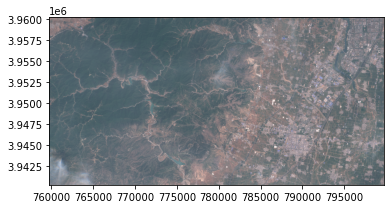

CPU times: user 1.74 s, sys: 379 ms, total: 2.12 s
Wall time: 1.91 s


<AxesSubplot:>

In [5]:
%%time

import rasterio.plot as rstplt
import numpy as np

# From processing baseline PB04.00  values have an offset of 1_000
rstplt.show(np.clip((data_memory.values-1_000)/3_000,0,1), transform=data_memory.transform)

## Read from JPEG 2000 pyramids

Instead of reading at the highest possible resolution (10m in Sentinel-2) we can take advantage of the jp2 format of Sentinel-2 files and read the a footprint which might be much faster. See `Wall time` in the output cell bellow.

In [6]:
%%time

from georeader import rasterio_reader
from georeader.geotensor import GeoTensor

bands_reader = data.get_reader(["B04", "B03", "B02"])
data_memory = rasterio_reader.read_out_shape(bands_reader, size_read=600)
data_memory

CPU times: user 15 s, sys: 1.2 s, total: 16.2 s
Wall time: 33.4 s


 
         Transform: | 66.67, 0.00, 759760.00|
| 0.00,-66.67, 3960220.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 300, 600)
         Resolution: (66.66666666662786, 66.66666666651145)
         Bounds: (759760.0, 3940220.0, 799760.0, 3960220.0)
         CRS: EPSG:32649
         fill_value_default: 0
        

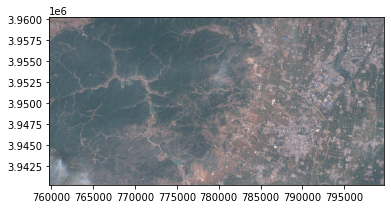

CPU times: user 348 ms, sys: 76.4 ms, total: 424 ms
Wall time: 213 ms


<AxesSubplot:>

In [7]:
%%time

rstplt.show(np.clip((data_memory.values-1_000)/3_000,0,1), transform=data_memory.transform)

In [8]:
%%time

data_pyramid = data.get_reader(["B04", "B03", "B02"], overview_level=3)
data_pyramid_memory = data_pyramid.load()
data_pyramid_memory

CPU times: user 4.24 s, sys: 1.2 s, total: 5.44 s
Wall time: 32.7 s


 
         Transform: | 159.83, 0.00, 759734.67|
| 0.00,-159.83, 3960223.49|
| 0.00, 0.00, 1.00|
         Shape: (3, 126, 251)
         Resolution: (159.8253275109455, 159.8253275109455)
         Bounds: (759734.6724890829, 3940085.502183406, 799850.8296943231, 3960223.4934497816)
         CRS: EPSG:32649
         fill_value_default: 0
        

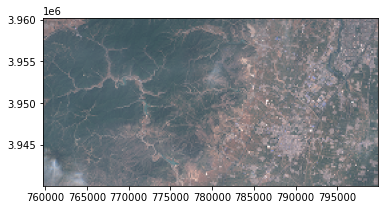

CPU times: user 322 ms, sys: 81 ms, total: 403 ms
Wall time: 221 ms


<AxesSubplot:>

In [9]:
%%time

rstplt.show(np.clip((data_pyramid_memory.values-1_000)/3_000,0,1), transform=data_pyramid_memory.transform)